I was also surprised to see that the vast majority of Python DCGAN implementations online are incorrect. Either not using fractional-strided CONVs, not properly freezing training, or using the incorrect activation function at a given time.

In [1]:
import pickle
import numpy as np
from __future__ import print_function

import tensorflow as tf

from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import *
from keras.layers import *
# from keras.optimizers import *
from keras.utils import np_utils
import keras
import keras.backend as K

import math
import random

import numpy as np

import cv2
from matplotlib import pyplot as plt
from tqdm import tqdm

%matplotlib inline

Using TensorFlow backend.


In [14]:
cl_data = pickle.load(open("classroom.pkl", "rb"), encoding='latin1')
X_train = np.array(cl_data)
X_train.shape
X_train = X_train.astype('float32')
X_train /= 255
X_train-=0.5

(10, 64, 64, 3)

In [8]:
train_datagen = ImageDataGenerator(
    preprocessing_function=lambda x: 2./255 * x - 1)

#test_datagen = ImageDataGenerator(preprocessing_function=lambda x: 2./255 * x - )

train_generator = train_datagen.flow_from_directory(
        'data/train',
        target_size=(64, 64),
        batch_size=2,
        class_mode=None)

#validation_generator = test_datagen.flow_from_directory(
#        'data/validation',
#        target_size=(150, 150),
#        batch_size=32,
#        class_mode='binary')

#model.fit_generator(
#        train_generator,
#        steps_per_epoch=2000,
#        epochs=50,
#        validation_data=validation_generator,
#        validation_steps=800)

Found 2 images belonging to 1 classes.


In [12]:
batch_size = 2 #128
nb_classes = 10
nb_epoch = 1
eps=1e-11

zed = 100

def cifar():
    # input image dimensions
    img_rows, img_cols = 32, 32
    # the CIFAR10 images are RGB
    img_channels = 3

    # the data, shuffled and split between train and test sets
    (X_train, y_train), (X_test, y_test) = cifar10.load_data()

    print('X_train shape:', X_train.shape)
    print(X_train.shape[0], 'train samples')
    print(X_test.shape[0], 'test samples')

    # convert class vectors to binary class matrices
    Y_train = np_utils.to_categorical(y_train, nb_classes)
    Y_test = np_utils.to_categorical(y_test, nb_classes)

    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')

    X_train /= 255
    X_test /= 255

    X_train-=0.5
    X_test-=0.5

    return X_train,Y_train,X_test,Y_test

#print('loading cifar...')
#xt,yt,xv,yv = cifar()

#print('loading data...')
#xt = X_train


def leaky_relu(i):
    return LeakyReLU(.2)(i)

def bn(i):
    return BatchNormalization()(i)

def gen2(): # generative network, 2
    inp = Input(shape=(zed,))
    i = inp
    i = Reshape((1,1,zed))(i)

    ngf=128 # nr of generator filters generated in first convolutional layer

    def deconv(i,nop,kw,oh,ow,std=1,tail=True,bm='same'):
        global batch_size
        i = Deconvolution2D(nop,kw,kw,subsample=(std,std),border_mode=bm,output_shape=(batch_size,oh,ow,nop))(i)
        if tail:
            i = bn(i)
            i = Activation('relu')(i)
        return i

    #i = deconv(i,nop=ngf*8,kw=4,oh=4,ow=4,std=1,bm='valid')
    #i = deconv(i,nop=ngf*4,kw=4,oh=8,ow=8,std=2)
    #i = deconv(i,nop=ngf*2,kw=4,oh=16,ow=16,std=2)
    #i = deconv(i,nop=ngf*1,kw=4,oh=32,ow=32,std=2)
    #i = deconv(i,nop=3,kw=4,oh=32,ow=32,std=1,tail=False) # out : 32x32
    
    i = deconv(i,nop=ngf*8,kw=8,oh=4,ow=4,std=1,bm='valid')
    i = deconv(i,nop=ngf*4,kw=8,oh=8,ow=8,std=2)
    i = deconv(i,nop=ngf*2,kw=8,oh=16,ow=16,std=2)
    i = deconv(i,nop=ngf*1,kw=8,oh=32,ow=32,std=2)
    i = deconv(i,nop=3,kw=8,oh=64,ow=64,std=1,tail=False) # out : 32x32
    i = Activation('tanh')(i)

    m = Model(input=inp,output=i)
    return m

def concat_diff(i): # batch discrimination - increase generation diversity.
    # return i
    bv = Lambda(lambda x:K.mean(K.abs(x[:] - K.mean(x,axis=0)),axis=-1,keepdims=True))(i)
    i = merge([i,bv],mode='concat')
    return i

def dis2(): # discriminative network, 2
    # inp = Input(shape=(None,None,3))
    inp = Input(shape=(64,64,3))
    i = inp

    ndf=128

    def conv(i,nop,kw,std=1,usebn=True,bm='same'):
        i = Convolution2D(nop,kw,kw,border_mode=bm,subsample=(std,std))(i)
        if usebn:
            i = bn(i)
        i = leaky_relu(i)
        return i

    #i = conv(i,ndf*1,4,std=2,usebn=False)
    #i = concat_diff(i)
    #i = conv(i,ndf*2,4,std=2)
    #i = concat_diff(i)
    #i = conv(i,ndf*4,4,std=2)
    #i = concat_diff(i)
    #i = conv(i,ndf*8,4,std=2)
    #i = concat_diff(i)
    
    i = conv(i,ndf*1,8,std=2,usebn=False)
    i = concat_diff(i)
    i = conv(i,ndf*2,8,std=2)
    i = concat_diff(i)
    i = conv(i,ndf*4,8,std=2)
    i = concat_diff(i)
    i = conv(i,ndf*8,8,std=4)
    i = concat_diff(i)

    print(i.shape)


    
    # 1x1
    i = Convolution2D(1,2,2,border_mode='valid')(i)

    i = Activation('linear',name='conv_exit')(i)
    i = Activation('sigmoid')(i)

    i = Reshape((1,))(i)

    m = Model(input=inp,output=i)
    return m

print('generating G...')
gm = gen2()
gm.summary()

print('generating D...')
dm = dis2()
dm.summary()

def gan(g,d):
    # initialize a GAN trainer

    # this is the fastest way to train a GAN in Keras
    # two models are updated simutaneously in one pass

    noise = Input(shape=g.input_shape[1:])
    real_data = Input(shape=d.input_shape[1:])

    generated = g(noise)
    gscore = d(generated)
    rscore = d(real_data)

    def log_eps(i):
        return K.log(i+1e-11)

    # single side label smoothing: replace 1.0 with 0.9
    dloss = - K.mean(log_eps(1-gscore) + .1 * log_eps(1-rscore) + .9 * log_eps(rscore))
    gloss = - K.mean(log_eps(gscore))

    Adam = tf.train.AdamOptimizer

    lr,b1 = 1e-4,.2 # otherwise won't converge.
    optimizer = Adam(lr,beta1=b1)

    grad_loss_wd = optimizer.compute_gradients(dloss, d.trainable_weights)
    update_wd = optimizer.apply_gradients(grad_loss_wd)

    grad_loss_wg = optimizer.compute_gradients(gloss, g.trainable_weights)
    update_wg = optimizer.apply_gradients(grad_loss_wg)

    def get_internal_updates(model):
        # get all internal update ops (like moving averages) of a model
        inbound_nodes = model.inbound_nodes
        input_tensors = []
        for ibn in inbound_nodes:
            input_tensors+= ibn.input_tensors
        updates = [model.get_updates_for(i) for i in input_tensors]
        return updates

    other_parameter_updates = [get_internal_updates(m) for m in [d,g]]
    # those updates includes batch norm.

    print('other_parameter_updates for the models(mainly for batch norm):')
    print(other_parameter_updates)

    train_step = [update_wd, update_wg, other_parameter_updates]
    losses = [dloss,gloss]

    learning_phase = K.learning_phase()

    def gan_feed(sess,batch_image,z_input):
        # actual GAN trainer
        nonlocal train_step,losses,noise,real_data,learning_phase

        res = sess.run([train_step,losses],feed_dict={
        noise:z_input,
        real_data:batch_image,
        learning_phase:True,
        # Keras layers needs to know whether
        # this run is training or testring (you know, batch norm and dropout)
        })

        loss_values = res[1]
        return loss_values #[dloss,gloss]

    return gan_feed

print('generating GAN...')
gan_feed = gan(gm,dm)

print('Ready. enter r() to train')



def r(ep=10000,noise_level=.01):
    sess = K.get_session()

    #np.random.shuffle(xt)
    #shuffled_cifar = xt
    #length = len(shuffled_cifar)

    
        # here's a more "manual" example
    for e in range(ep):
        print('Epoch', e)
        batches = 0
        for x_batch in train_generator:
            
            z_input = np.random.normal(loc=0.,scale=1.,size=(batch_size,zed))

            losses = gan_feed(sess,x_batch,z_input)
            print('dloss:{:6.4f} gloss:{:6.4f}'.format(losses[0],losses[1]))            

            batches += 1
            if batches >= 2 / 2: # len(x_train) / 2
                # we need to break the loop by hand because
                # the generator loops indefinitely
                break
    
    #for i in range(ep):
    #    noise_level *= 0.99
    #    print('---------------------------')
    #    print('iter',i,'noise',noise_level)
    #
    #    # sample from cifar
    #    j = i % int(length/batch_size)
    #    minibatch = shuffled_cifar[j*batch_size:(j+1)*batch_size]
    #    # minibatch += np.random.normal(loc=0.,scale=noise_level,size=subset_cifar.shape)
    #
    #    z_input = np.random.normal(loc=0.,scale=1.,size=(batch_size,zed))
    #
    #    # train for one step
    #    losses = gan_feed(sess,minibatch,z_input)
    #    print('dloss:{:6.4f} gloss:{:6.4f}'.format(losses[0],losses[1]))
    #
    #    if i==ep-1 or i % 10==0: pass #show()

def autoscaler(img):
    limit = 400.
    # scales = [0.1,0.125,1./6.,0.2,0.25,1./3.,1./2.] + range(100)
    scales = np.hstack([1./np.linspace(10,2,num=9), np.linspace(1,100,num=100)])

    imgscale = limit/float(img.shape[0])
    for s in scales:
        if s>=imgscale:
            imgscale=s
            break

    img = cv2.resize(img,dsize=(int(img.shape[1]*imgscale),int(img.shape[0]*imgscale)),interpolation=cv2.INTER_NEAREST)

    return img,imgscale

def flatten_multiple_image_into_image(arr):
    import cv2
    num,uh,uw,depth = arr.shape

    patches = int(num+1)
    height = int(math.sqrt(patches)*0.9)
    width = int(patches/height+1)

    img = np.zeros((height*uh+height, width*uw+width, 3),dtype='float32')

    index = 0
    for row in range(height):
        for col in range(width):
            if index>=num-1:
                break
            channels = arr[index]
            img[row*uh+row:row*uh+uh+row,col*uw+col:col*uw+uw+col,:] = channels
            index+=1

    img,imgscale = autoscaler(img)

    return img,imgscale

def show(save=False):
    i = np.random.normal(loc=0.,scale=1.,size=(batch_size,zed))
    gened = gm.predict([i])

    gened *= 0.5
    gened +=0.5

    im,ims = flatten_multiple_image_into_image(gened)
    #cv2.imshow('gened scale:'+str(ims),im)
    #cv2.waitKey(1)
    plt.imshow(im)
    plt.show()

    if save!=False:
        cv2.imwrite(save,im*255)

generating G...


//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:58: UserWarning: Update your `Conv2DTranspose` call to the Keras 2 API: `Conv2DTranspose(1024, (8, 8), strides=(1, 1), padding="valid")`
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:58: UserWarning: Update your `Conv2DTranspose` call to the Keras 2 API: `Conv2DTranspose(512, (8, 8), strides=(2, 2), padding="same")`
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:58: UserWarning: Update your `Conv2DTranspose` call to the Keras 2 API: `Conv2DTranspose(256, (8, 8), strides=(2, 2), padding="same")`
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:58: UserWarning: Update your `Conv2DTranspose` call to the Keras 2 API: `Conv2DTranspose(128, (8, 8), strides=(2, 2), padding="same")`
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:58: UserWarning: Update your `Conv2DTranspose` call to the Keras 2 API: `Conv2DTranspose(3, (8, 8), strides=(1, 1), padding="same")`
//anaconda/lib/pytho

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 100)               0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 1, 1, 100)         0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 8, 8, 1024)        6554624   
_________________________________________________________________
batch_normalization_8 (Batch (None, 8, 8, 1024)        4096      
_________________________________________________________________
activation_7 (Activation)    (None, 8, 8, 1024)        0         
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 16, 16, 512)       33554944  
_________________________________________________________________
batch_normalization_9 (Batch (None, 16, 16, 512)       2048      
__________

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:83: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
//anaconda/lib/python3.5/site-packages/keras/legacy/layers.py:458: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:94: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (8, 8), strides=(2, 2), padding="same")`
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:94: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(512, (8, 8), strides=(2, 2), padding="same")`
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:94: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(1024, (8, 8), strides=(4, 4), padding="same")`
/

(?, 2, 2, 1025)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_6 (InputLayer)             (None, 64, 64, 3)     0                                            
____________________________________________________________________________________________________
conv2d_6 (Conv2D)                (None, 32, 32, 128)   24704       input_6[0][0]                    
____________________________________________________________________________________________________
leaky_re_lu_5 (LeakyReLU)        (None, 32, 32, 128)   0           conv2d_6[0][0]                   
____________________________________________________________________________________________________
lambda_5 (Lambda)                (None, 32, 32, 1)     0           leaky_re_lu_5[0][0]              
___________________________________________________________________________

In [15]:
r(ep=10)

Epoch 0
dloss:2.0878 gloss:3.7579
Epoch 1
dloss:2.0660 gloss:1.5966
Epoch 2
dloss:1.4340 gloss:24.2435
Epoch 3
dloss:1.6752 gloss:13.4873
Epoch 4
dloss:2.8064 gloss:6.6614
Epoch 5
dloss:27.8613 gloss:-0.0000
Epoch 6
dloss:27.8613 gloss:-0.0000
Epoch 7
dloss:27.8613 gloss:-0.0000
Epoch 8
dloss:27.8613 gloss:-0.0000
Epoch 9
dloss:27.8613 gloss:-0.0000


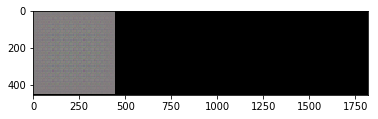

In [16]:
show()

In [ ]:
xt.shape